# Project 4: Web Scraping Job Postings
## Elliot Contreras
https://git.generalassemb.ly/DSI-SF-6/DSI-SF-6-project-four

### 1. Determine the industry factors that are most important in predicting the salary amounts for these data.
### 2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:

- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models<br/>
<br/>Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key. Note that most listings DO NOT come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?
- You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [81]:
import pandas as pd
import numpy as np
import scrapy
import matplotlib.pyplot as plt
import urllib2 #return userip address, make a function
from bs4 import BeautifulSoup
import requests
from scrapy.selector import Selector
import unidecode
import re
import time
import urllib, json
%matplotlib inline

pd.set_option('display.max_columns', 50)

### Establishing base functions

In [82]:
# This function returns a list of words, only letters, stopwords removed and lowercased
from nltk.corpus import stopwords

def words_to_wordlist( row, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", row)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [83]:
import datetime, pytz
# TIME VARIABLE BELOW WILL BE USED MULTIPLE TIMES FOR SAVING CSV
# POSSIBLY FOR A TIME CHECK TO MAKE SURE TWITTER CALLS ARE WITHIN TIME LIMIT

# Current time in UTC
def current_pacific_time():
    fmt = '%Y_%m_%d_%H_%M_%S'
    now_utc = datetime.datetime.now(pytz.timezone('UTC'))
    now_pacific = now_utc.astimezone(pytz.timezone('US/Pacific'))
    return now_pacific.strftime(fmt)

# CALL THIS VARIABLE BEFORE SAVING SO CURRENT PACIFIC TIME IS EMBEDDED
current_pacific_time()

'2017_05_19_13_30_48'

In [5]:
# exporting tweets dataframe, so information can be used later on
def save_dataframe(df, name='some_text'):
    if type(df) == pd.core.frame.DataFrame:
        df.to_csv('./'+name+'_'+current_pacific_time()+'.csv', encoding='utf-8', index=False)
        print 'Exported to: ./'+name+'_'+current_pacific_time()+'.csv'
    else:
        print 'No dataset selected'

In [84]:
# Function to convert utc timestamp to pacific timestamp
def created_at_to_pacific(row):
    try:
        #row = str(row)
        t = datetime.datetime.strptime(str(row.values[0]).replace('T', ' ').rstrip('.000000000'), "%Y-%m-%d %H:%M:%S")
        t = t.replace(tzinfo=pytz.timezone('UTC'))
        t = t.astimezone(pytz.timezone('US/Pacific'))
        return t
    except:
        return row

### Mining the Data using the Indeed api

In [85]:
# Setting up the publisher ID to be used with the indeed api
from indeed import IndeedClient

client = IndeedClient(publisher = 4030041204556404)

In [93]:
##### CUSTOM MADE MINER USING THE INDEED API 

# Empty list to add the mined entries
search_responses = []

# These are the salary ranges for data science positions
salaries = ['$65,000', '$90,000', '$105,000', '$115,000', '$130,000']

# These are the cities to search for
cities = ['San Francisco, CA', 'Los Angeles, CA', 'New York, NY', 'Seattle, WA']

# Useragent is needed for the api call
mozilla = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.81 Safari/537.36'

# indeed api call through http
indeed_http = 'http://api.indeed.com/ads/apisearch?publisher=[PUBLISHER_KEY]&'

# query or search term
q = 'data scientist'

# manually set the salary index
sal = 1

query = urllib.urlencode({'q': q })+'+'+salaries[sal].replace('$', '%24').replace(',', '%2C')+'&'
        
for i in range(0,1000,25):
            # settings for parameters
    parameters = {        'q' : q,
                              'l' : cities[2], 
                           'start': i+1, 
                         'fromage': 'any', 
                          'filter': 1, 
                          'userip': '38.140.30.202', 
                      'useragent' : mozilla, 
                               'v': 2, 
                          'format': 'json'
            }
            # encoding http + query + parameters into an http link
    url = indeed_http+urllib.urlencode(parameters)
    response = requests.get(url)
            
            # results are returned as json dictionaries
    for result in json.loads(response.text)['results']:
        result['salary'] = salaries[sal]
                # Seperating results, and getting them into a pandas dataframe
        search_responses.append(result)

# casting results into a pandas dataframe
df = pd.DataFrame(search_responses)
print df.shape, 'Original df'

# Dropping the duplicate rows
df = df[~df.duplicated(subset='jobkey', keep='first')]
print df.shape, 'With Duplicates Removed'
df.sample()

(400, 20) Original df
(400, 20) With Duplicates Removed


,city,company,country,date,expired,formattedLocation,formattedLocationFull,formattedRelativeTime,indeedApply,jobkey,jobtitle,language,onmousedown,salary,snippet,source,sponsored,state,stations,url
42,New York,Pronoun,US,"Wed, 10 May 2017 00:46:11 GMT",False,"New York, NY","New York, NY",9 days ago,False,1fb18b6d76c9db25,Senior Data Scientist,en,"indeed_clk(this,'4328');","$90,000",You are a seasoned <b>data</b> <b>scientist</b...,Macmillan,False,NY,,http://www.indeed.com/viewjob?jk=1fb18b6d76c9d...


In [87]:
# run once to create a list to hold the mined dataframes
all_dataframes = []

In [94]:
# code above is ran several times independent from a loop. I found that running it in a loop did not collect enough information
all_dataframes.append(df)

In [95]:
df = pd.concat(all_dataframes)
print df.shape

(1600, 20)


In [96]:
df = df[~df.duplicated(subset='jobkey', keep='first')]
print df.shape

(801, 20)


In [97]:
# Looking at the columns
df.columns

Index([                 u'city',               u'company',
                     u'country',                  u'date',
                     u'expired',     u'formattedLocation',
       u'formattedLocationFull', u'formattedRelativeTime',
                 u'indeedApply',                u'jobkey',
                    u'jobtitle',              u'language',
                 u'onmousedown',                u'salary',
                     u'snippet',                u'source',
                   u'sponsored',                 u'state',
                    u'stations',                   u'url'],
      dtype='object')

In [98]:
# Going to remove the following columns
remove_cols = ['formattedRelativeTime', 'formattedLocationFull', 'onmousedown', 'sponsored', 'stations',
              'expired', 'indeedApply', 'language', 'source', 'formattedLocation', 'snippet']
df.drop(remove_cols, axis=1, inplace=True) # = [col for col in df.columns if col not in remove_cols]
df.sample()

,city,company,country,date,jobkey,jobtitle,salary,state,url
31,South San Francisco,Genentech,US,"Thu, 20 Apr 2017 21:50:36 GMT",fa0b0ae0c3408f12,Senior Real World Data Scientist,"$90,000",CA,http://www.indeed.com/viewjob?jk=fa0b0ae0c3408...


### Tests for description retrieval using the requests/scrapy selector

In [21]:
# TEST: retrieving the url
df.iloc[10]['url']

u'http://www.indeed.com/viewjob?jk=f926c72340fcd61a&qd=QjlBLq1gvKpCBnWQ-cPpj5GJT91Mro23yoPu5mU11GcPF99BKVcs3YfEl1HphPQYdDaKx4Q9EWKhSK2ttYA8J2y5iKhDm2WBzw3MJWKrZDg7wGLdADaDT7GfF8rF-S-6NVbuGkvXR_7b87sG_geiaw&indpubnum=4030041204556404&atk=1bgf82t8bag9m876'

In [24]:
# requesting the html page
url = df.iloc[10]['url']
response = requests.get(url)
response.text[:100]

u'<!DOCTYPE html>\n<html lang="en">\n<head><title>Analytic Consultant 1 job - Wells Fargo - San Francisc'

In [25]:
# extracting the description
xpath_query = "//span[@id='job_summary']/text()"
s = ''
description = Selector(text=response.text).xpath(xpath_query).extract()

# decoding the unicode into ascii, and removing the newlines
# Uniting into an entire string
for d in description:
    s += unidecode.unidecode(d)#.replace('\n', ' ').replace(',', '')#.strip('\n')
s

"Job Description\n\n\nOur foundation for success can be summarized in three beliefs:\n\nOur product is service.\n\nOur value added is financial advice and guidance.\n\nOur competitive advantage is our people. It all begins with outstanding talent.\n\n\nIn Payments, Virtual Solutions and Innovation (PVSI), we've built our team of top professionals by rewarding their accomplishments and ensuring they have what's needed to succeed. We value and promote diversity and inclusion in every aspect of our business and at every level of our organization.\n\n\nThe PVSI team includes Consumer Credit Card, Retail Services, Consumer Deposits, Treasury Management, Merchant Services and Wells Fargo Virtual Channels including the professional services teams that partner with these businesses and other key partners.\n\n\nThis role will be part of the Cards and Retail Services Analytics team. The Analytics team is comprised of experts representing data scientists, analytics, data infrastructure management

### Successful test to get the description.
### Now to mine the information...

In [100]:
# Functions to retrieve description and ratings from mined indeed jobs
def get_description(row):
    '''use on the ["url"].map() column to create the ["description"] column
    '''
    url = row
    response = requests.get(url)
    xpath_query = "//span[@id='job_summary']/text()"
    description = Selector(text=response.text).xpath(xpath_query).extract()
    s = ''
    for d in description:
        s += unidecode.unidecode(d)#.replace('\n', ' ').replace(',', '')#.strip('\n')
    return s

def get_description_tokens(row):
    '''use on the ["description"].map column to create the ["description_tokens"] column
    '''
    # converts description column to tokenised word list
    words = words_to_wordlist(row, remove_stopwords=True)
    return words

def get_ratings(row):
    '''use on the ["url"].map() column to create the ["company_rating"] column
    '''
    url = row
    response = requests.get(url)
    xpath_query = "//span[@class='rating']"
    # attempts to extract the rating, but defaults to 0.5 if non-existant
    try:
        rating = Selector(text=response.text).xpath(xpath_query).extract()[0]
        
        title_search = re.search("(\d\d.\d)", rating, re.IGNORECASE)
        
        if title_search:
            title = title_search.group(1)
        
        return float(title) / 60
        
    except:
        # default to .5 as a baseline average out of 1.0
        return .5

In [101]:
# Generating values for the following columns
df['description']       = df['url'].map(lambda x: get_description(x))
df['description_token'] = df['description'].map(lambda x: get_description_tokens(x))
df['company_rating']    = df['url'].map(lambda x: get_ratings(x))

# Converting the date column to a datetime format, and to pacific time, so it is more reasonable for us
# I am at Pacific Time
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].map(lambda x: created_at_to_pacific(x))

# Looking at a sample to see the changes
df.sample()

,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating
331,South San Francisco,Thermo Fisher Scientific,US,2017-05-03 10:33:50,196345348fcd7ff5,Bioinformatics Scientist III- Software,"$90,000",CA,http://www.indeed.com/viewjob?jk=196345348fcd7...,"When you're part of Thermo Fisher Scientific, ...","[part, thermo, fisher, scientific, challenging...",0.71


In [102]:
# salary to int
df['salary'] = df['salary'].map(lambda x: int(x.lstrip('$').replace(',','')))
df.sample()

,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating
223,San Mateo,"Medallia, Inc.",US,2017-04-25 18:47:06,c79445a17bb9cd6c,"VP, Data Science & Engineering",90000,CA,http://www.indeed.com/viewjob?jk=c79445a17bb9c...,Medallia is the global leader in Customer Expe...,"[medallia, global, leader, customer, experienc...",0.74


In [103]:
# No more rows with missing data
df[df['city'] == '']

,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating


In [104]:
# saving the dataframe
save_dataframe(df=df, name='indeed_')

Exported to: ./indeed__2017_05_19_13_40_04.csv


### EDA

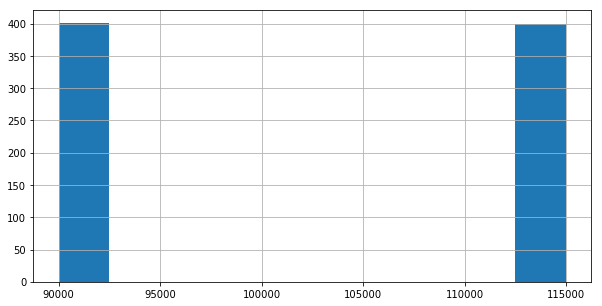

In [105]:
df['salary'].hist(figsize=(10,5))

Due to the mining process, there are only jobs within these two ranges

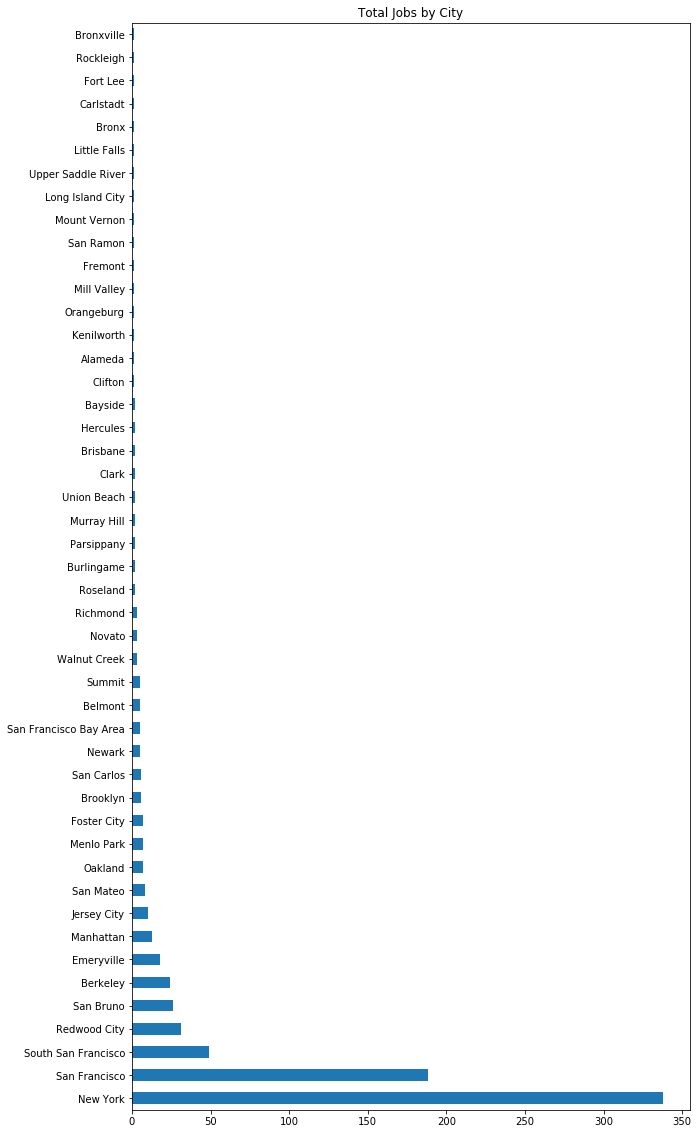

In [106]:
# Total Jobs by Location
df['city'].value_counts().plot(kind='barh', figsize=(10,20), title='Total Jobs by City')

Most of the jobs seem to be in New York City, with San Francisco in second

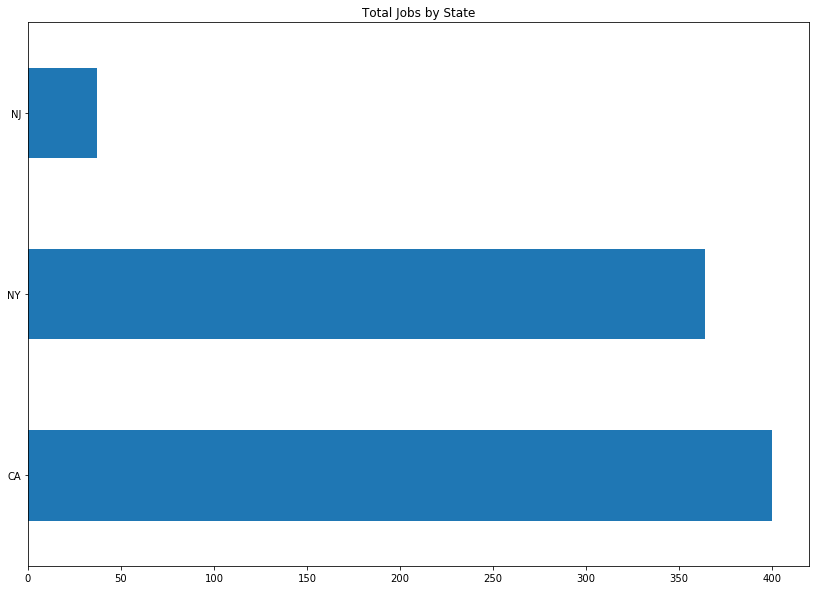

In [107]:
# Total Jobs by Location
df['state'].value_counts().plot(kind='barh', figsize=(14,10), title='Total Jobs by State')

Unlike the graph before, the entirety of jobs are in California

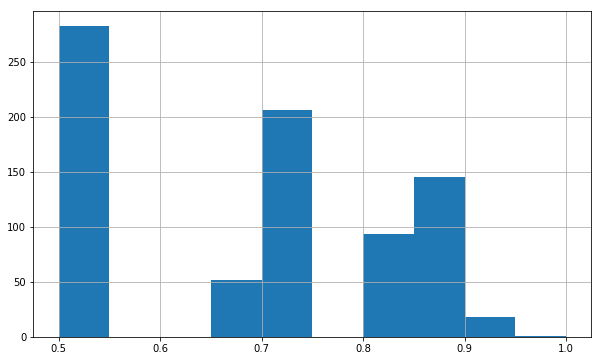

In [108]:
# Distribution of Company Ratings
df['company_rating'].hist(bins=10, figsize=(10,6))

The majority of companies are rated at 0.5 because they did not have any rating and 0.5 was set as a default value.<br/>
If we ignore that fact, then most companies are rated at 0.75, with the rest above 0.8. <br/>

In [109]:
df.sort_values('company_rating', ascending=False).head()

,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating
256,New York,Venturi Ltd,US,2017-03-04 21:09:05,f81ac6582ae10fdb,Big Data Engineer / Hadoop Developer ( FinTech...,115000,NY,http://www.indeed.com/viewjob?jk=f81ac6582ae10...,,[],1.00
175,San Ramon,Diverse Lynx,US,2017-05-06 03:26:05,64ac867d239934c1,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=64ac867d23993...,Position - Data Scientist\n\n\n\n\n\n\n\n1.Can...,"[position, data, scientist, candidates, hold, ...",0.94
288,New York,Foursquare,US,2017-04-11 18:06:20,1f058a26a00f2e51,Senior Data Engineer,115000,NY,http://www.indeed.com/viewjob?jk=1f058a26a00f2...,"\nSince our inception in 2009, Foursquare has ...","[since, inception, foursquare, leading, force,...",0.93
368,San Francisco,The Climate Corporation,US,2017-02-25 06:55:07,00f75b177e12d8f4,Mobile Architect,90000,CA,http://www.indeed.com/viewjob?jk=00f75b177e12d...,Position Overview:\n\n\nThought leaders to arc...,"[position, overview, thought, leaders, archite...",0.92
20,New York,Quartet,US,2017-05-17 19:37:38,2a04f8cfdd285838,Data Scientist - Functional Data Insights,115000,NY,http://www.indeed.com/viewjob?jk=2a04f8cfdd285...,The Data Insights Team is looking for an entre...,"[data, insights, team, looking, entrepreneuria...",0.92


In [110]:
# Restting index because of four dataframes concatenated together
df = df.reset_index(drop=True)
df.head()

,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating
0,San Francisco,Grammarly,US,2017-05-06 05:06:39,69784db6e1db4ab5,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=69784db6e1db4...,The Opportunity\n\nEffective communication is ...,"[opportunity, effective, communication, hard, ...",0.50
1,San Francisco,Kabbage,US,2017-05-13 06:14:11,d0309de406984ef7,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=d0309de406984...,**********************************************...,"[use, machine, learning, big, data, help, kabb...",0.50
2,San Francisco,Affirm,US,2017-01-28 09:28:53,43919ef2aba8622b,"Data Scientist, Analytics",90000,CA,http://www.indeed.com/viewjob?jk=43919ef2aba86...,Do you love bringing data to life and driving ...,"[love, bringing, data, life, driving, data, dr...",0.50
3,San Francisco,Eventbrite,US,2017-02-10 02:10:38,420ff65bc2b15f9c,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=420ff65bc2b15...,THE CHALLENGE \nThe Analytics & Data Science t...,"[challenge, analytics, data, science, team, wo...",0.65
4,San Francisco,Tapjoy,US,2017-05-18 17:42:05,bee22aa6d94caf95,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=bee22aa6d94ca...,Tapjoy's Maximum Impact PlatformTM provides mo...,"[tapjoy, maximum, impact, platformtm, provides...",0.69


### Modeling Phase
### Preparing the data for the modeling phase

In [111]:
# programming languages used as search words in the description
prog_lang = ['r', 'python', 'java', 'c++', 'ruby', 'data', 'science','perl', 'matlab', 
 'machine', 'learning', 'nlp', 'javascript', 'aws', 'spark', 'hadoop']

In [112]:
# Setting up the dataframe to allow for the count of programming words
for p in prog_lang:
    df[p] = 0
df.head(1)
# Iterating through the programming languages, and creating a column with said word

,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating,r,python,java,c++,ruby,data,science,perl,matlab,machine,learning,nlp,javascript,aws,spark,hadoop
0,San Francisco,Grammarly,US,2017-05-06 05:06:39,69784db6e1db4ab5,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=69784db6e1db4...,The Opportunity\n\nEffective communication is ...,"[opportunity, effective, communication, hard, ...",0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


With the tokenized description, the words are counted and checked against the programming languages

In [114]:
# Iterating over every row
for index, row in df.iterrows():
    # counting the words in the description
    # remove hashtag on the end if dataframe was loaded as a csv ----->>>
    words = row['description_token']#.lstrip('[').rstrip(']').replace(',', '').split(' ')
    # Creating a temporary dictionary
    temp_dict = {}
    for word in words:
        if word not in temp_dict:
            temp_dict[word] = 1
        else:
            temp_dict[word] += 1
    # Casting the dictionary as a pandas dataframe    
    temp = pd.DataFrame.from_dict([temp_dict])
    # these words will be removed from the dataframe as they are not in the programming language list
    p_cols = [col for col in temp.columns if col not in prog_lang]
    # dropping those extra columns/words
    temp.drop(p_cols, axis=1, inplace=True)
    # casting columns as a set
    a = set(temp.columns)
    b = set(prog_lang)
    # getting the difference to fill in the missing data in the temp dataframe
    for col in list(b.difference(a)):
        temp[col] = 0
    # setting the values onto the dataframe from the temporary dataframe
    for p in prog_lang:
        row[p] = int(temp[p].values)
    df.iloc[index] = row

        
df.head()

,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating,r,python,java,c++,ruby,data,science,perl,matlab,machine,learning,nlp,javascript,aws,spark,hadoop
0,San Francisco,Grammarly,US,2017-05-06 05:06:39,69784db6e1db4ab5,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=69784db6e1db4...,The Opportunity\n\nEffective communication is ...,"[opportunity, effective, communication, hard, ...",0.50,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
1,San Francisco,Kabbage,US,2017-05-13 06:14:11,d0309de406984ef7,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=d0309de406984...,**********************************************...,"[use, machine, learning, big, data, help, kabb...",0.50,0,0,0,0,0,6,1,0,0,2,2,1,0,0,0,0
2,San Francisco,Affirm,US,2017-01-28 09:28:53,43919ef2aba8622b,"Data Scientist, Analytics",90000,CA,http://www.indeed.com/viewjob?jk=43919ef2aba86...,Do you love bringing data to life and driving ...,"[love, bringing, data, life, driving, data, dr...",0.50,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
3,San Francisco,Eventbrite,US,2017-02-10 02:10:38,420ff65bc2b15f9c,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=420ff65bc2b15...,THE CHALLENGE \nThe Analytics & Data Science t...,"[challenge, analytics, data, science, team, wo...",0.65,0,0,0,0,0,10,2,0,0,0,0,0,0,0,0,0
4,San Francisco,Tapjoy,US,2017-05-18 17:42:05,bee22aa6d94caf95,Data Scientist,90000,CA,http://www.indeed.com/viewjob?jk=bee22aa6d94ca...,Tapjoy's Maximum Impact PlatformTM provides mo...,"[tapjoy, maximum, impact, platformtm, provides...",0.69,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0


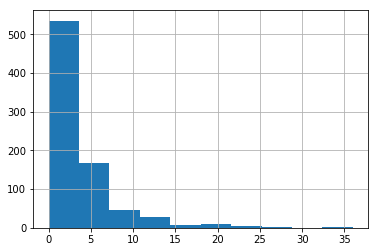

In [182]:
df[prog_lang]['data'].hist()

In [115]:
# Exporting the dataframe
save_dataframe(df=df, name='indeed_')

Exported to: ./indeed__2017_05_19_13_48_48.csv


In [116]:
from sklearn.preprocessing import LabelEncoder

In [117]:
le = LabelEncoder()

In [119]:
# function to label encode columns
def encode_columns(col):
    df[col+'_enc'] = le.fit_transform(df[col])
    print 'Label Encoded:', col

In [123]:
# label encoding these columns
le_columns = ['city', 'company', 'state', 'jobtitle', 'salary']
for column in le_columns:
    encode_columns(column)
df.sample()

Label Encoded: city
Label Encoded: company
Label Encoded: state
Label Encoded: jobtitle
Label Encoded: salary


,city,company,country,date,jobkey,jobtitle,salary,state,url,description,description_token,company_rating,r,python,java,c++,ruby,data,science,perl,matlab,machine,learning,nlp,javascript,aws,spark,hadoop,city_enc,company_enc,state_enc,jobtitle_enc,salary_enc
445,New York,Logic Corporation,US,2017-05-08 11:24:14,d9f256fe03f53e8b,Senior Data Scientist,115000,NY,http://www.indeed.com/viewjob?jk=d9f256fe03f53...,,[],0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,239,2,535,1


In [124]:
# Getting the encoded information with the actual value to be used as reference
encoded_list = []
for col in le_columns:
    temp_zip = zip(sorted(set(df[col].values)), sorted(set(df[col+'_enc'].values)))
    encoded_list.append(temp_zip)
encoded_list[0][:3]

[(u'Alameda', 0), (u'Bayside', 1), (u'Belmont', 2)]

In [125]:
# looking at the columns
df.columns

Index([             u'city',           u'company',           u'country',
                    u'date',            u'jobkey',          u'jobtitle',
                  u'salary',             u'state',               u'url',
             u'description', u'description_token',    u'company_rating',
                       u'r',            u'python',              u'java',
                     u'c++',              u'ruby',              u'data',
                 u'science',              u'perl',            u'matlab',
                 u'machine',          u'learning',               u'nlp',
              u'javascript',               u'aws',             u'spark',
                  u'hadoop',          u'city_enc',       u'company_enc',
               u'state_enc',      u'jobtitle_enc',        u'salary_enc'],
      dtype='object')

In [126]:
# Creating a new dataframe with just the encoded columns
df_q1 = df.drop(['city','company','country', 'date', 'jobkey', 'jobtitle',
                 'salary', 'state', 'url', 'description', 'description_token'], axis=1)
df_q1.sample()

,company_rating,r,python,java,c++,ruby,data,science,perl,matlab,machine,learning,nlp,javascript,aws,spark,hadoop,city_enc,company_enc,state_enc,jobtitle_enc,salary_enc
747,0.85,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,26,92,2,134,1


In [127]:
# Creating X and y variables
y = df_q1['salary_enc']
X_copy = df_q1.drop('salary_enc', axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_copy)

In [128]:
from sklearn.model_selection import train_test_split

In [129]:
# Creating the trainging and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Modeling phase

In [169]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [143]:
# First attempt will be done with logistic regression.
# Making an attempt to predict salary
# Salary is binary in this case with only two options, 90000 and 115000
logreg = LogisticRegression(C=2, random_state=0)
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.99245283018867925

0.99 Seems to good to be true, I will make an attempt with cross validation

In [172]:
# Cross Validation Classification Accuracy
scoring = 'accuracy'
results = cross_val_score(logreg, X_train, y_train, cv=5, scoring=scoring)
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())

# Cross Validation Classification ROC AUC
scoring = 'roc_auc'
results = cross_val_score(logreg, X_train, y_train, cv=5, scoring=scoring)
print("AUC: %.3f (%.3f)") % (results.mean(), results.std())

# Cross Validation Classification LogLoss
scoring = 'neg_log_loss'
results = cross_val_score(logreg, X_train, y_train, cv=5, scoring=scoring)
print("Logloss: %.3f (%.3f)") % (results.mean(), results.std())

# Confusion Matrix
predicted = logreg.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print 'Confusion Matrix:'
print(matrix)

# Classification report
report = classification_report(y_test, predicted)
print(report)

Accuracy: 0.996 (0.005)
AUC: 0.999 (0.001)
Logloss: -0.027 (0.021)
Confusion Matrix:
[[138   0]
 [  2 125]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       138
          1       1.00      0.98      0.99       127

avg / total       0.99      0.99      0.99       265



The ROC curve score is very close to 1, indicating that the model performed almost perfectly. <br/>
The logloss is somewhat close to 0.

In [150]:
# Basic LogisticRegressionCV
logregCV = LogisticRegressionCV(Cs=2, cv=5, random_state=0)
logregCV.fit(X_train, y_train)
logregCV.score(X_test, y_test)

0.99622641509433962

In [151]:
# Looking at the coeffiecients which contributed to the predictions
sorted(zip(logreg.coef_[0], list(X_copy.columns)), reverse=True)

[(5.8641559522749027, 'state_enc'),
 (0.31084529744611267, 'company_rating'),
 (0.25352197954843808, 'r'),
 (0.048524081245409349, 'java'),
 (0.0, 'c++'),
 (-0.0079904201327861447, 'hadoop'),
 (-0.010185959269003177, 'aws'),
 (-0.029235952021984764, 'data'),
 (-0.065540654272674317, 'nlp'),
 (-0.070752749573741891, 'company_enc'),
 (-0.078044092227832609, 'ruby'),
 (-0.085190063779131242, 'jobtitle_enc'),
 (-0.088419467816429592, 'python'),
 (-0.11055337467464781, 'spark'),
 (-0.13911172613907871, 'javascript'),
 (-0.17881339975029617, 'matlab'),
 (-0.18067117256170817, 'science'),
 (-0.2187766065321258, 'learning'),
 (-0.22720950090761161, 'city_enc'),
 (-0.24002845056134459, 'machine'),
 (-0.46493706311550537, 'perl')]

It looks like the state has a lot to do with the prediction on salary. In further tests, I would like to mine more data with a higher diversity in locations. The company rating does contribute to the predictions. I would assume that a company with a higher rating is somewhere that people want to work at, and they may in fact pay more. The programming language r is a contributer to the predictions, but python is not that much. In fact java is up there, but it may be because there are job postings not related to data science.

In [152]:
from sklearn.ensemble import ExtraTreesClassifier

In [155]:
# Making an attempt with an ExtraTreesClassifier
extra = ExtraTreesClassifier(random_state=0, max_depth=3, n_estimators=15, n_jobs=3, max_features=.5, class_weight='balanced')
extra.fit(X_train, y_train)
extra.score(X_test, y_test)

1.0

In [154]:
sorted(zip(extra.feature_importances_, X_copy.columns), reverse=True)

[(0.87644330484962274, 'state_enc'),
 (0.10510884415768683, 'city_enc'),
 (0.0039553185112012378, 'perl'),
 (0.002805530044674728, 'company_enc'),
 (0.0028009818948864645, 'company_rating'),
 (0.0015957879181250994, 'hadoop'),
 (0.0013426433735829473, 'science'),
 (0.0012627736668628796, 'r'),
 (0.0012492174557269214, 'spark'),
 (0.0010372026769806047, 'learning'),
 (0.00058301024783039923, 'java'),
 (0.00054497830201690801, 'data'),
 (0.0005055857804549161, 'python'),
 (0.00025202625370828434, 'matlab'),
 (0.00024875621890547062, 'aws'),
 (0.00014730592584304286, 'machine'),
 (0.00011673272189056313, 'javascript'),
 (0.0, 'ruby'),
 (0.0, 'nlp'),
 (0.0, 'jobtitle_enc'),
 (0.0, 'c++')]

In [173]:
# Cross Validation Classification Accuracy
scoring = 'accuracy'
results = cross_val_score(extra, X_train, y_train, cv=5, scoring=scoring)
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())

# Cross Validation Classification ROC AUC
scoring = 'roc_auc'
results = cross_val_score(extra, X_train, y_train, cv=5, scoring=scoring)
print("AUC: %.3f (%.3f)") % (results.mean(), results.std())

# Cross Validation Classification LogLoss
scoring = 'neg_log_loss'
results = cross_val_score(extra, X_train, y_train, cv=5, scoring=scoring)
print("Logloss: %.3f (%.3f)") % (results.mean(), results.std())

# Confusion Matrix
predicted = extra.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print 'Confusion Matrix:'
print(matrix)

# Classification report
report = classification_report(y_test, predicted)
print(report)

Accuracy: 0.998 (0.004)
AUC: 0.996 (0.008)
Logloss: -0.164 (0.132)
Confusion Matrix:
[[138   0]
 [  0 127]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       138
          1       1.00      1.00      1.00       127

avg / total       1.00      1.00      1.00       265



Again, it seems that location has a major impact on the predictions. Looking at the information, there are only three states: CA, NY, NJ. Further tests imply that a better diversity of locations may affect the predicitons.

In [156]:
# Making an attempt with KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [158]:
input_dim = X_train.shape[1]

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    return model


estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=50, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 99.75% (0.31%)


In [175]:
# Cross Validation Classification Accuracy
scoring = 'accuracy'
results = cross_val_score(estimator, X_train, y_train, cv=5, scoring=scoring)
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())

# Cross Validation Classification ROC AUC
scoring = 'roc_auc'
results = cross_val_score(estimator, X_train, y_train, cv=5, scoring=scoring)
print("AUC: %.3f (%.3f)") % (results.mean(), results.std())

# Cross Validation Classification LogLoss
scoring = 'neg_log_loss'
results = cross_val_score(estimator, X_train, y_train, cv=5, scoring=scoring)
print("Logloss: %.3f (%.3f)") % (results.mean(), results.std())

Accuracy: 0.993 (0.009)
AUC: 1.000 (0.000)
Logloss: -0.030 (0.015)


For now, I can accurately predict salary with 99% accuracy. Given more information, and a wider variety of salaries, this accuracy may change. 

### Classification of job titles

In [183]:
# Creating a new dataframe with just the encoded columns
df_q2 = df.drop(['city','company','country', 'date', 'jobkey', 'jobtitle',
                 'salary', 'state', 'url', 'description', 'description_token'], axis=1)
df_q2.sample()

,company_rating,r,python,java,c++,ruby,data,science,perl,matlab,machine,learning,nlp,javascript,aws,spark,hadoop,city_enc,company_enc,state_enc,jobtitle_enc,salary_enc
624,0.5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,26,229,2,445,1


In [200]:
# Creating X and y variables
y = df_q2['jobtitle_enc']
X_copy = df_q2.drop('jobtitle_enc', axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_copy)

In [201]:
# Creating the trainging and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [202]:
# Making an attempt with an ExtraTreesClassifier
extra = ExtraTreesClassifier(random_state=0, n_estimators=200, n_jobs=3, max_features=.5, class_weight='balanced')
extra.fit(X_train, y_train)
extra.score(X_test, y_test)

0.01509433962264151

In [199]:
# Unique job titles
print len(sorted(set(y.unique())))
print y.shape
print 669./y.shape[0]
print y.shape[0]-669

669
(801,)
0.835205992509
132


There are 669 unique job titles. In this model, it means that there are 669 targets out of 801 rows. Or the equivalent to 83/100. Further tests require to just mine jobs with the exact given titles. This will help with the classification. There is too much variance in the job titles to accurately classify.

In [191]:
# Features that contribute to job title
sorted(zip(extra.feature_importances_, X_copy.columns), reverse=True)

[(0.23917803347240807, 'company_enc'),
 (0.18879181025043504, 'data'),
 (0.11631834758369962, 'company_rating'),
 (0.098195713705245269, 'city_enc'),
 (0.070991849976522109, 'science'),
 (0.050633696517518763, 'learning'),
 (0.046587581655659127, 'r'),
 (0.035708639032932067, 'machine'),
 (0.031695735816996161, 'python'),
 (0.020605794910194777, 'state_enc'),
 (0.01551140908372118, 'salary_enc'),
 (0.014793975655838209, 'spark'),
 (0.014336482484452118, 'hadoop'),
 (0.014272908662482828, 'java'),
 (0.011551775259461819, 'javascript'),
 (0.007866300837623668, 'nlp'),
 (0.0075920759959800755, 'matlab'),
 (0.0073874075077346758, 'aws'),
 (0.0042855517145712115, 'ruby'),
 (0.0036949098765233375, 'perl'),
 (0.0, 'c++')]

Looking at the feature importances, it seems that the company feature, the word data, and company rating weigh higher in the classification. It would make sense that the words 'data' and 'science' are among the top 5 features that classify the job title.

r 180
python 130
java 58
c++ 0
ruby 12
data 2718
science 620
perl 10
matlab 22
machine 334
learning 451
nlp 21
javascript 22
aws 27
spark 73
hadoop 54


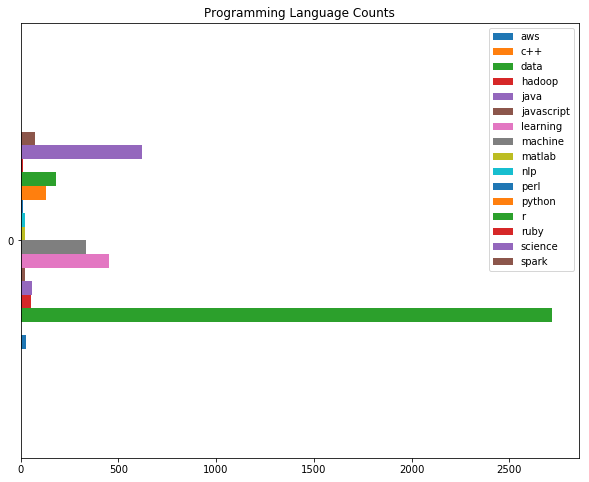

In [240]:
# Collecting a count of all programming languages in the mined data
temp_d = {}
for lang in prog_lang:
    print lang, df_q2[lang].sum()
    temp_d[lang] = df_q2[lang].sum()
    
lang_counts_df = pd.DataFrame([temp_d])
lang_counts_df.plot(kind='barh', figsize=(10,8), title='Programming Language Counts')

As a way to classify the job title, I may go a different approach with EDA. Getting a total count of words said in all of the mined job postings, we can start to see a group of words that stand out in 'Data Scietist' listings. The word 'data' is among the highest with 2718 different occurences. In fact: 'data', 'science', 'machine', 'learning' are the top words. The programming languages that are the most mentioned are 'r', 'python', 'spark', and 'java'. Disclaimer, further tests will include a higher vocabulary of search words to match to Data Scientist job postings (Including the most obvious and missing in this case, 'sql').